In [1]:
import torch
import rdkit.Chem.Draw
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
import utils
import json

In [2]:
with open("data/name_to_smiles.json") as f:
    name_to_smiles = json.load(f)
smiles_to_name = {v:k for k,v in name_to_smiles.items()}
next(iter(name_to_smiles.items())), next(iter(smiles_to_name.items()))

(('amyl butyrate', 'CCCCCOC(=O)CCC'), ('CCCCCOC(=O)CCC', 'amyl butyrate'))

In [3]:
with open("../dataset/full.json") as f:
    full_data = json.load(f)
full_data[0]

{'mol1': 'CCCCC/C=C/C(=O)OC',
 'mol1_notes': ['violet',
  'sweet',
  'oily',
  'melon',
  'pear',
  'hairy',
  'costus',
  'fruity',
  'violet leaf',
  'waxy',
  'fresh',
  'green'],
 'mol2': 'CCCCCOC(=O)CCC',
 'mol2_notes': ['cherry',
  'sweet',
  'pineapple',
  'fruity',
  'banana',
  'tropical'],
 'blend_notes': ['animal', 'fruity', 'waxy']}

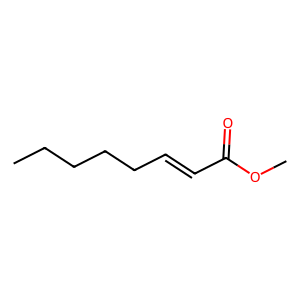

In [4]:
from rdkit import Chem
import rdkit.Chem.Draw

def im_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.Draw.MolToImage(mol)

im_from_smiles(full_data[0]["mol1"])

In [5]:
def find(mol1,mol2):
    results = [d for d in full_data if (d["mol1"] == mol1 and d["mol2"] == mol2) or (d["mol1"] == mol2 and d["mol2"] == mol1)]
    assert len(results) == 1
    return results[0]
find("CC(C)CC=O","CC=O")

{'mol1': 'CC(C)CC=O',
 'mol1_notes': ['chocolate', 'peach', 'fatty', 'aldehydic', 'ethereal'],
 'mol2': 'CC=O',
 'mol2_notes': ['musty',
  'pungent',
  'fruity',
  'aldehydic',
  'fresh',
  'ethereal'],
 'blend_notes': ['pungent']}

In [6]:
import matplotlib.pyplot as plt

bp = 3
def format_long_notes(notes):
    notes = [f"\"{note}\"" for note in notes]
    if len(notes) < bp:
        return ', '.join(notes)
    formatted_strings = [f'{s},' if i % bp != 2 else f'{s},\n' for i, s in enumerate(notes)]
    return ' '.join(formatted_strings).strip()[:-1]

def format(name,notes):
    # Matplotlib is annoying and combines words used in a single bf mathtext.
    # Split, bold, then rejoin.
    return f"{name}\n{format_long_notes(notes)}"


def make(fname,data,title):
    # plt.rc('text', usetex=True)
    fig, axarr = utils.standard_fig_ax(1,2)
    axarr[0].imshow(im_from_smiles(data["mol1"]))
    axarr[0].set_title(format(f"{bold(smiles_to_name[data['mol1']])}",data['mol1_notes']))
    axarr[1].imshow(im_from_smiles(data["mol2"]))
    axarr[1].set_title(format(f"{bold(smiles_to_name[data['mol2']])}",data['mol2_notes']))
    # Remove ticks but keep boxes around molecules.
    for ax in axarr:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(format(title,data["blend_notes"]),y=.85)
    plt.tight_layout()
    utils.save_figures(fname,fig)
    plt.show()
    
def bold(sentence):
    # Matplotlib is annoying and combines words used in a single bf mathtext.
    # Split, bold, then rejoin.
    return " ".join([r'$\bf{' + w + '}$' for w in sentence.split()])

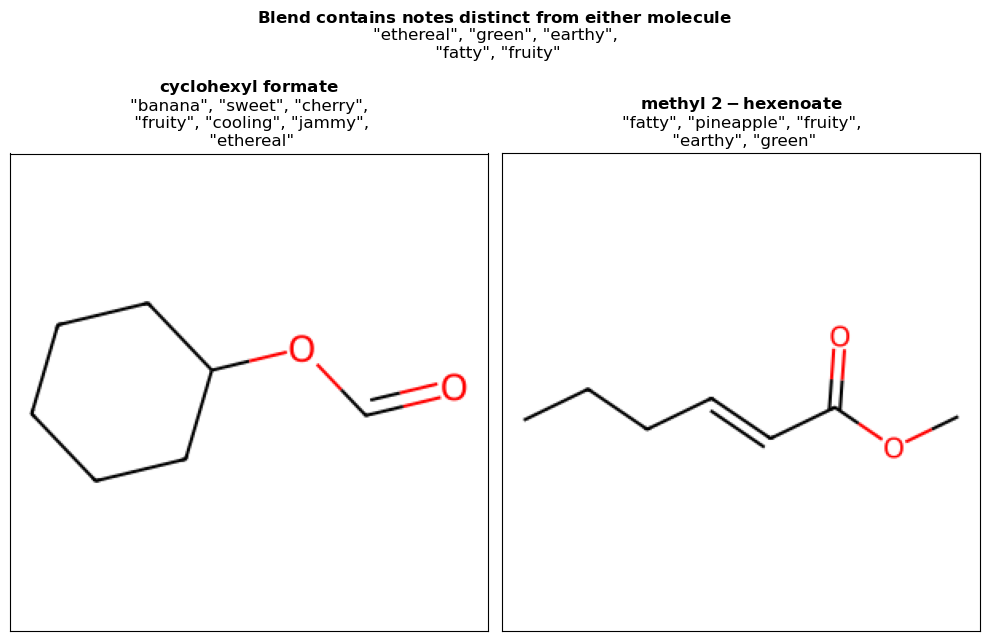

In [7]:
make("blendedpair",find("CCCC=CC(=O)OC","C1CCC(CC1)OC=O"),bold("Blend contains notes distinct from either molecule"))

In [8]:
with open("data/coefficients.json") as f:
    coefficients = json.load(f)
coeffs = np.array(coefficients["coeffs"])
r2s = np.array(coefficients["r2s"])
idcs = np.array(coefficients["idcs"])
scoeffs = sorted(coeffs,key=lambda p: p[0])
x,y = zip(*scoeffs)

In [9]:
print("Looking for a highgly non-linear pair")
for idx, r2 in enumerate(r2s):
    if r2 > 4e-2:
        continue

    d = full_data[idcs[idx]]
    if len(d["mol1_notes"]) > 3 or len(d["mol2_notes"]) > 3:
        continue

    print(r2, x[idx], y[idx])



    print(d["mol1_notes"],d["mol2_notes"],d["blend_notes"])
    print(d["mol1"],d["mol2"])
    print()

Looking for a highgly non-linear pair
0.025515571733112585 -0.6059980392456055 8.43689250946045
['mustard', 'pungent'] ['mustard', 'pungent'] ['mustard']
C=CCN=C=S C=CCO

0.03415883954990939 1.3749966621398926 2.1577014923095703
['fresh', 'pineapple'] ['pineapple', 'fruity'] ['fruity']
CCC/C=C\CCC(=O)OC CCOC(=O)CCCC=C

0.03602714374387628 1.8103241920471191 9.942835807800293
['apple', 'juicy', 'natural'] ['fresh', 'pineapple'] ['fruity']
CC/C=C\CC(OCC)OCC CCC/C=C\CCC(=O)OC

0.029119765639856077 2.0834267139434814 8.468317031860352
['floral', 'tropical', 'fruity'] ['fruity'] ['fruity']
CC1=CC(=C(O1)C)SC(=O)C CC\C=C/CC(=O)OC

0.03510860510346736 3.3214526176452637 1.1934746503829956
['fruity', 'ethereal'] ['green', 'grassy', 'fruity'] ['fruity']
CCCCC(=O)OCC(C)C CCOCC=C(C)C

0.032886956807893775 3.6726431846618652 3.9071547985076904
['green', 'grassy', 'fruity'] ['green', 'pear', 'fruity'] ['green', 'fruity']
CC1COC(O1)C COC(=O)CC/C=C/CC=C

0.021304242364973303 4.5565290451049805 1.97340

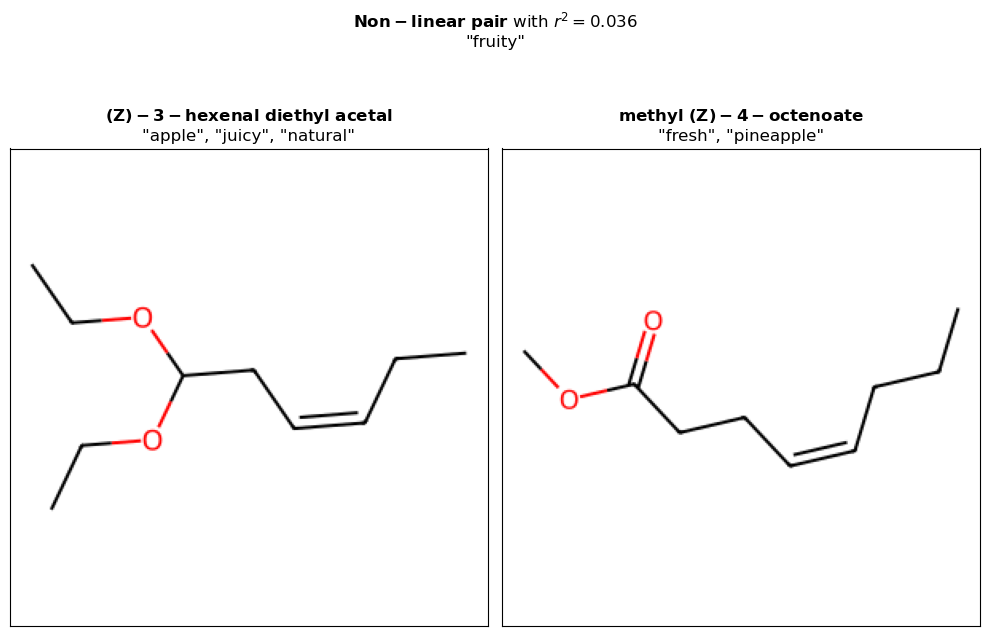

In [10]:
make("nonlinear",find("CC/C=C\CC(OCC)OCC","CCC/C=C\CCC(=O)OC"), f"{bold('Non-linear pair')} with " + r"$r^2 = 0.036$")

In [11]:
print("Looking for highly linear pair")
for idx, r2 in enumerate(r2s):
    if r2 < .90:
        continue
    if x[idx] < 15:
        continue

    d = full_data[idcs[idx]]
    if len(d["mol1_notes"]) > 3 or len(d["mol2_notes"]) > 3:
        continue

    print(r2, x[idx], y[idx])



    print(d["mol1_notes"],d["mol2_notes"],d["blend_notes"])
    print(d["mol1"],d["mol2"])
    print()

Looking for highly linear pair
0.9296750564132163 17.267976760864258 -6.776614665985107
['rummy', 'fruity', 'honey'] ['sandalwood', 'floral', 'honey'] ['woody']
C=CCOC(=O)CC1=CC=CC=C1 CC(COC(=O)Cc1ccccc1)=CCCC3(C)C(=C)C2CC3CC2

0.9215909140584385 23.6552677154541 -14.932479858398438
['herbal', 'floral', 'balsamic'] ['herbal', 'floral', 'green'] ['balsamic']
C1CCC(CC1)OC(=O)C2=CC=CC=C2 CC(C)CCCC(C)CCCC(C)CCCC(C)(C=C)O



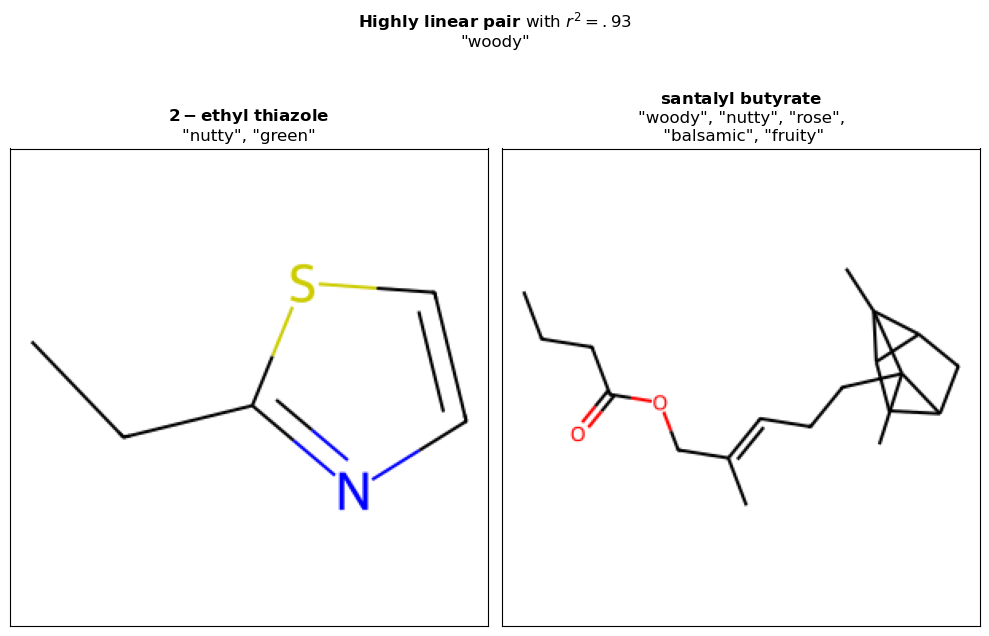

In [12]:
make("highlylinear",find("CCC1=NC=CS1","CCCC(=O)OC/C(=C/CCC1(C2CC3C1(C3C2)C)C)/C"), f"{bold('Highly linear pair')} with " + r"$r^2 = .93$")

In [13]:
print("Looking for a pair where the second molecule predominates")
for idx, r2 in enumerate(r2s):
    if r2 < .90:
        continue
    if x[idx] > -10:
        continue
    d = full_data[idcs[idx]]
    print(r2, x[idx], y[idx])
    print(d["mol1_notes"],d["mol2_notes"],d["blend_notes"])
    print(d["mol1"],d["mol2"])
    print()

Looking for a pair where the second molecule predominates
0.9364974168045465 -26.284543991088867 32.61901092529297
['floral', 'rose', 'apple', 'fruity'] ['woody', 'nutty', 'rose', 'balsamic', 'fruity'] ['woody']
C/C=C\C(=O)C1C(=CCCC1(C)C)C CCCC(=O)OC/C(=C/CCC1(C2CC3C1(C3C2)C)C)/C

0.9480820097552465 -21.68546485900879 33.0473747253418
['sandalwood', 'floral', 'honey'] ['spicy', 'sweet', 'almond', 'floral', 'fruity', 'honey', 'waxy'] ['woody', 'honey', 'floral']
CC(COC(=O)Cc1ccccc1)=CCCC3(C)C(=C)C2CC3CC2 COC(=O)CC1=CC=CC=C1

0.9276566455313066 -19.88304901123047 31.134851455688477
['cashew', 'orris', 'berry', 'powdery', 'woody', 'nutty', 'floral', 'violet', 'acidic', 'green'] ['orris', 'raspberry', 'berry', 'powdery', 'woody', 'floral', 'fruity', 'violet'] ['woody', 'floral', 'berry']
C/C(=C/CC[C@@]1([C@H]2CC[C@H](C2)C1=C)C)/COC(=O)C.C/C(=C/CC[C@@]1(C2C[C@@H]3C1(C3C2)C)C)/COC(=O)C CC1=CCCC(C1CCC(=O)C)(C)C



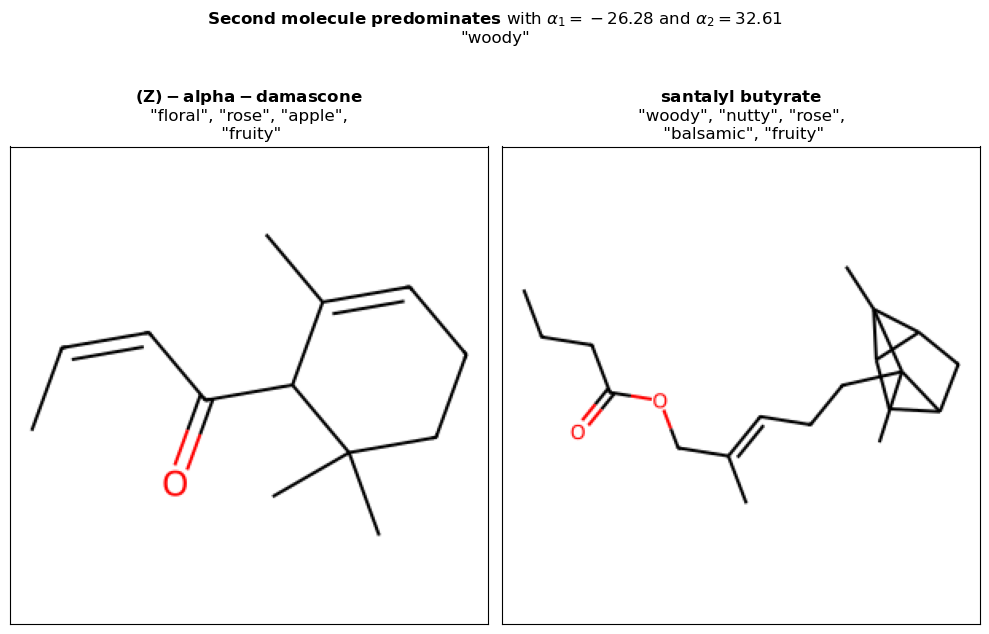

In [14]:
make("secondpredominates",find("C/C=C\C(=O)C1C(=CCCC1(C)C)C","CCCC(=O)OC/C(=C/CCC1(C2CC3C1(C3C2)C)C)/C"), f"{bold('Second molecule predominates')} with " +  r"$\alpha_1 = -26.28$ and $\alpha_2 = 32.61$")

In [15]:
print("Looking for a pair where the first molecule predominates")
for idx, r2 in enumerate(r2s):
    if r2 < .90:
        continue
    if x[idx] < 15:
        continue

    d = full_data[idcs[idx]]
    if len(d["mol1_notes"]) > 3 or len(d["mol2_notes"]) > 3:
        continue

    print(r2, x[idx], y[idx])



    print(d["mol1_notes"],d["mol2_notes"],d["blend_notes"])
    print(d["mol1"],d["mol2"])
    print()

Looking for a pair where the first molecule predominates
0.9296750564132163 17.267976760864258 -6.776614665985107
['rummy', 'fruity', 'honey'] ['sandalwood', 'floral', 'honey'] ['woody']
C=CCOC(=O)CC1=CC=CC=C1 CC(COC(=O)Cc1ccccc1)=CCCC3(C)C(=C)C2CC3CC2

0.9215909140584385 23.6552677154541 -14.932479858398438
['herbal', 'floral', 'balsamic'] ['herbal', 'floral', 'green'] ['balsamic']
C1CCC(CC1)OC(=O)C2=CC=CC=C2 CC(C)CCCC(C)CCCC(C)CCCC(C)(C=C)O



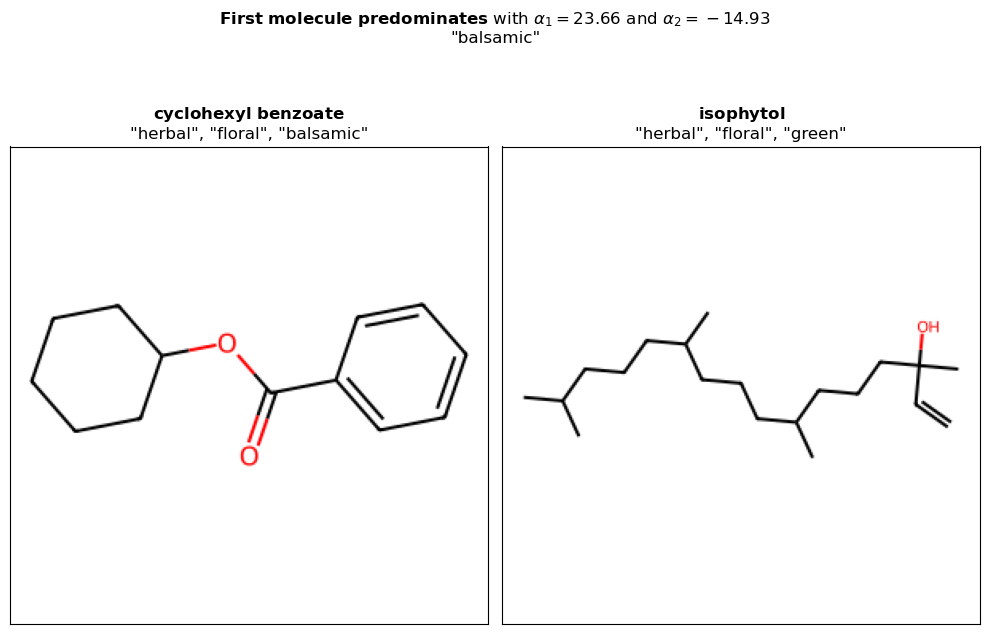

In [16]:
make("firstpredominates",find("C1CCC(CC1)OC(=O)C2=CC=CC=C2","CC(C)CCCC(C)CCCC(C)CCCC(C)(C=C)O"), f"{bold('First molecule predominates')} with " +  r"$\alpha_1 = 23.66$ and $\alpha_2 = -14.93$")